<a href="https://colab.research.google.com/github/sera0911/asia_ai_study/blob/main/New_MachinLearning/exam_11_predict_daily_stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##삼성전자 종가 예측하기(LSTM 사용하여 시계열 데이터 예측하기)



In [3]:
#모듈 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *  #레이어 전체를 가져온다
from tensorflow.keras.optimizers import Adam

In [4]:
#파일 불러오기(삼성 주식 데이터)
raw_data = pd.read_csv('Samsung.csv')
print(raw_data.head())

         Date    Open    High     Low   Close    Adj Close      Volume
0  2000-01-04  6000.0  6110.0  5660.0  6110.0  4740.119629  74195000.0
1  2000-01-05  5800.0  6060.0  5520.0  5580.0  4328.947754  74680000.0
2  2000-01-06  5750.0  5780.0  5580.0  5620.0  4359.979492  54390000.0
3  2000-01-07  5560.0  5670.0  5360.0  5540.0  4297.916992  40305000.0
4  2000-01-10  5600.0  5770.0  5580.0  5770.0  4476.349121  46880000.0


In [5]:
print(raw_data.tail())

            Date     Open     High      Low    Close  Adj Close      Volume
5385  2021-06-07  82700.0  82800.0  81600.0  81900.0    81900.0  16496197.0
5386  2021-06-08  82300.0  82600.0  81800.0  81900.0    81900.0  12781226.0
5387  2021-06-09  81500.0  82000.0  81100.0  81100.0    81100.0  14908823.0
5388  2021-06-10  81300.0  81400.0  80900.0  81000.0    81000.0  17586995.0
5389  2021-06-11  81200.0  81700.0  80700.0  81000.0    81000.0  14087962.0


In [6]:
print(raw_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5390 entries, 0 to 5389
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5390 non-null   object 
 1   Open       5384 non-null   float64
 2   High       5384 non-null   float64
 3   Low        5384 non-null   float64
 4   Close      5384 non-null   float64
 5   Adj Close  5384 non-null   float64
 6   Volume     5384 non-null   float64
dtypes: float64(6), object(1)
memory usage: 294.9+ KB
None


In [7]:
data_close = raw_data[['Close']]  #종가만 확인해보기
print(data_close.head())

    Close
0  6110.0
1  5580.0
2  5620.0
3  5540.0
4  5770.0


In [30]:
data_close = data_close.sort_values("Close")  #Close컬럼을 정렬시키기
print(data_close.head())
print(data_close.tail(10))

      Close
206  2730.0
205  2740.0
214  2750.0
452  2810.0
453  2810.0
        Close
5288  89700.0
5287  89700.0
5286  90600.0
5285  91000.0
1304      NaN
4513      NaN
4518      NaN
4542      NaN
4755      NaN
5000      NaN


In [9]:
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
raw_data.set_index('Date', inplace=True)  #Date 컬럼을 인덱스로 사용, 원본에 반영시키기 위하여 inplace=True로 준다
raw_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4740.119629,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,4328.947754,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,4359.979492,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,4297.916992,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,4476.349121,46880000.0


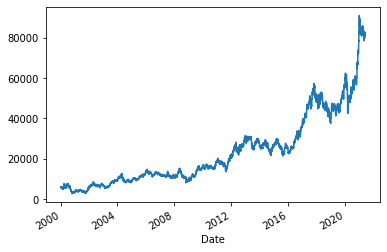

In [10]:
#종가를 기준으로 그래프그리기

raw_data['Close'].plot()
plt.show()

In [11]:
#1년치 데이터만 확인해보기

data = raw_data['2019-06-15' : '2020-06-14'][['Close']]
print(data.head())
print(data.tail())
print(data.info())

              Close
Date               
2019-06-17  43900.0
2019-06-18  44350.0
2019-06-19  45350.0
2019-06-20  45500.0
2019-06-21  45700.0
              Close
Date               
2020-06-08  54900.0
2020-06-09  55500.0
2020-06-10  55400.0
2020-06-11  54300.0
2020-06-12  52300.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 246 entries, 2019-06-17 to 2020-06-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   245 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB
None


In [12]:
data.dropna(subset=['Close'], inplace=True)  #null값 처리하기
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 245 entries, 2019-06-17 to 2020-06-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   245 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB
None


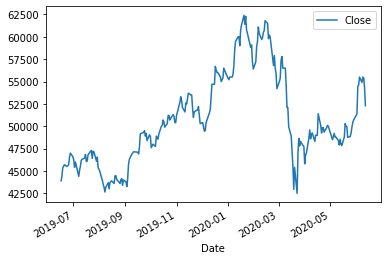

In [13]:
data.plot()
plt.show()

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
#데이터 MinMaxScaler 스케일링

minmaxscaler = MinMaxScaler()
scaled_data = minmaxscaler.fit_transform(data)
print(scaled_data[:6])  #minmaxscaler를 하면 데이터프레임이 깨지고 np.array가 된다
print(scaled_data.shape)

[[0.07035176]
 [0.09296482]
 [0.14321608]
 [0.15075377]
 [0.16080402]
 [0.15075377]]
(245, 1)


In [16]:
sequence_X = []
sequence_Y = []
for i in range(len(scaled_data) - 28 ):  #28개씩 잘라준다
    _x = scaled_data[i : i+28]  #i부터 i+28 = 28개의 데이터
    _y = scaled_data[i+28]  #i+28번째의 값 (그 다음순서의 값을 예측해야하니까)
    if i is 0:
        print(_x, '->', _y)
    sequence_X.append(_x)
    sequence_Y.append(_y)

[[0.07035176]
 [0.09296482]
 [0.14321608]
 [0.15075377]
 [0.16080402]
 [0.15075377]
 [0.15577889]
 [0.16080402]
 [0.20100503]
 [0.22613065]
 [0.20603015]
 [0.18844221]
 [0.14572864]
 [0.1758794 ]
 [0.15829146]
 [0.09547739]
 [0.13065327]
 [0.15326633]
 [0.18592965]
 [0.19095477]
 [0.19849246]
 [0.21859296]
 [0.17839196]
 [0.18090452]
 [0.2160804 ]
 [0.2361809 ]
 [0.24120603]
 [0.1959799 ]] -> [0.2361809]


RNN 모델은 정해진 수만큼 자르고, 그 다음 순서를 예측하는 것   
 RNN이 기존의 뉴럴 네트워크와 다른 점은 ‘기억’(다른 말로 hidden state)을 갖고 있다는 점

이 데이터는 시계열 데이터라서 순서가 중요하다, 그래서 데이터순서를 시퀀스 시키는 것

1~8 을 4씩 자른다면(x) y는 그 다음 예측할 값

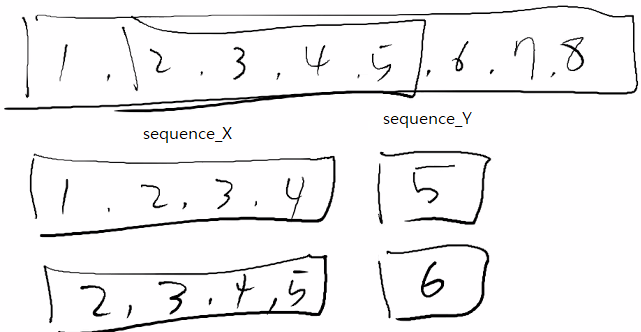

In [17]:
sequence_X = np.array(sequence_X)
sequence_Y = np.array(sequence_Y)

print(sequence_X[1])  #28개의 데이터
print(sequence_Y[1])  #그 다음 예측할 값 y=1개의 데이터
print(sequence_X.shape)  #28개 빼서 217개의 데이터 , 28개가 한개씩 묶인 리스트 217개
print(sequence_Y.shape)  #정답데이터는 1개씩 묶인 217개의 리스트

[[0.09296482]
 [0.14321608]
 [0.15075377]
 [0.16080402]
 [0.15075377]
 [0.15577889]
 [0.16080402]
 [0.20100503]
 [0.22613065]
 [0.20603015]
 [0.18844221]
 [0.14572864]
 [0.1758794 ]
 [0.15829146]
 [0.09547739]
 [0.13065327]
 [0.15326633]
 [0.18592965]
 [0.19095477]
 [0.19849246]
 [0.21859296]
 [0.17839196]
 [0.18090452]
 [0.2160804 ]
 [0.2361809 ]
 [0.24120603]
 [0.1959799 ]
 [0.2361809 ]]
[0.23366834]
(217, 28, 1)
(217, 1)


In [18]:
#훈련과 검증 set으로 나누기

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    sequence_X, sequence_Y, test_size=0.2)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(173, 28, 1)
(173, 1)
(44, 28, 1)
(44, 1)


In [19]:
#모델 생성

model = Sequential() #시퀀스란 데이터를 순서대로 하나씩 나열하여 나타낸 데이터 구조

#input_shape=(X_train.shape[0], X_train.shape[1]) 인 이유는 자르는 갯수가 달라지더라도 train.shape로 해놓으면 변경되는 대로 적용되서(현재 적용된 건(28, 1))
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))  #LSTM 일 때는 activation='thah'로 해줘야 한다(하이퍼볼릭 탄젠트)
model.add(Flatten())
model.add(Dense(1))  #값 자체를 예측하기 때문에 activation을 사용하지 않는다

model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#모델 학습시키기

fit_hist = model.fit(X_train, Y_train, epochs=500, validation_data=(X_test, Y_test), shuffle=False)  #validation_data=(X_test, Y_test) 이렇게 데이터를 줘도 된다(여기는 학습하지 않음)

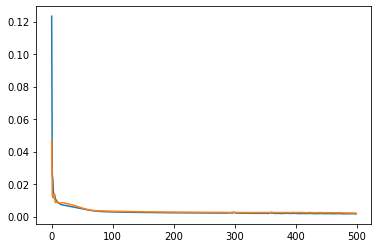

In [23]:
plt.plot(fit_hist.history['loss'])
plt.plot(fit_hist.history['val_loss'])
plt.show()

In [25]:
#예측하기
predict = model.predict(X_test)

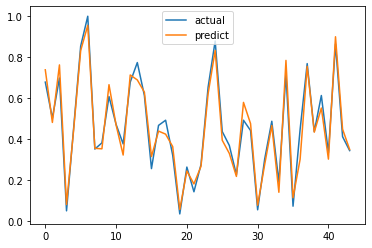

In [27]:
plt.plot(Y_test, label='actual') #실제값
plt.plot(predict, label='predict') #예측값
plt.legend()
plt.show()

이 퍼셉트론이 결과적으로 out5가 t로 나올 수 있도록 학습하는 것이 RNN이다   
길면 길수록 학습이 잘 안나오게 된다

(실제 퍼셉트론은 한개만 있다, 하나씩 들어갈 때를 쉽게 보여주려고 과정을 그린 것)

단기기억 - 옛데이터는 많이 손실되어, 최근 데이터가 예측을 하는 데 중요한 것(RNN)  
장기기억 - 옛데이터들까지 기억이 될 수 있게 모든 데이터를 선으로 나타내 준 것(LSTM)  

LSTM에서는 메모리 공간이 충분한 동안에는 메모리의 정보를 오랜시간 보존할 수 있다.   
하지만 RNN의 경우, 특정 길이 이상으로는, 과거의 있던 메모리를 잊기 시작한다  

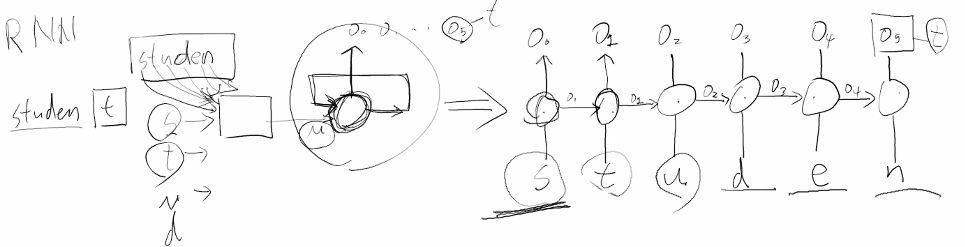

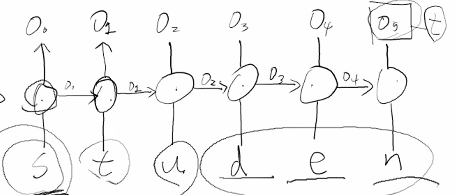